# Dartsの公式サイトのexample
https://unit8co.github.io/darts/examples/darts-intro.html

In [14]:
import sys
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    StandardRegressionModel,
    Theta,
    FFT
)
from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.utils.statistics import check_seasonality, plot_acf

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

## データの読み込み

In [2]:
df = pd.read_csv('../data/AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', ['#Passengers'])

In [3]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


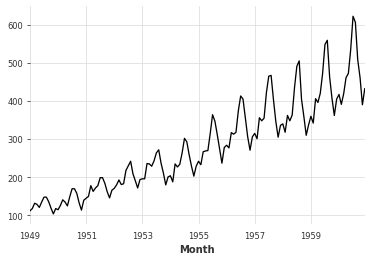

In [13]:
fig, ax = plt.subplots()
series.plot(ax=ax)

## train & validation

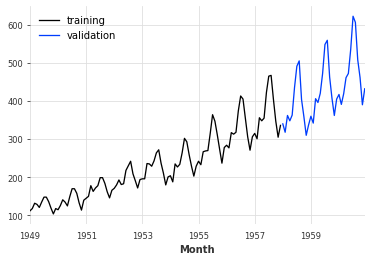

In [12]:
train, val = series.split_before(pd.Timestamp('19580101'))

fig, ax = plt.subplots()
train.plot(label='training', ax=ax)
val.plot(label='validation', ax=ax)
ax.legend(loc='best')

## Theta method

In [6]:
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

一番良かったthetaを確認

In [7]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print('The MAPE is: {:.2f}, with theta = {}.'.format(mape(val, pred_best_theta), best_theta))

The MAPE is: 4.40, with theta = -3.5102040816326543.


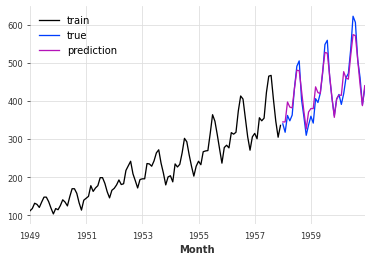

In [11]:
fig, ax = plt.subplots()
train.plot(label='train', ax=ax)
val.plot(label='true', ax=ax)
pred_best_theta.plot(label='prediction', ax=ax)
ax.legend(loc='best')

かなりいい感じ

In [9]:
best_theta

-3.5102040816326543

## Backtesting

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Average error (MAPE) over all historical forecasts: 6.194975117563356
Median error (MAPE) over all historical forecasts: 4.2892315467043565


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

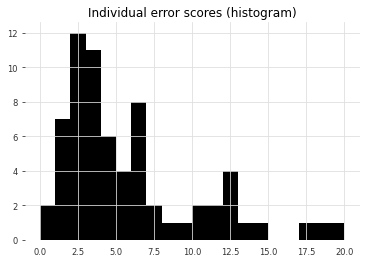

In [10]:
average_error = best_theta_model.backtest(series, start=pd.Timestamp('19550101'), forecast_horizon=3, verbose=True)
median_error = best_theta_model.backtest(series, start=pd.Timestamp('19550101'), forecast_horizon=3, reduction=np.median, verbose=True)
print("Average error (MAPE) over all historical forecasts: {}".format(average_error))
print("Median error (MAPE) over all historical forecasts: {}".format(median_error))

raw_errors = best_theta_model.backtest(series, start=pd.Timestamp('19550101'), forecast_horizon=3, reduction=None, verbose=True)
fig, ax = plt.subplots()
ax.hist(raw_errors, bins=np.arange(0, max(raw_errors), 1))
ax.set_title("Individual error scores (histogram)")

historical_fcast_theta = best_theta_model.historical_forecasts(series, start=pd.Timestamp('19550101'), forecast_horizon=3, verbose=True)

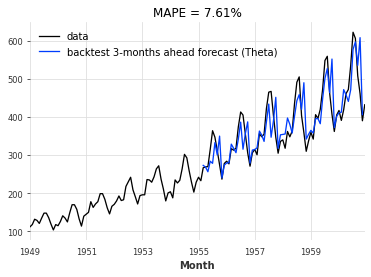

In [15]:
fig, ax = plt.subplots()
series.plot(label='data', ax=ax)
historical_fcast_theta.plot(label='backtest 3-months ahead forecast (Theta)', ax=ax)
ax.set_title('MAPE = {:.2f}%'.format(mape(historical_fcast_theta, series)))
ax.legend(loc='best')

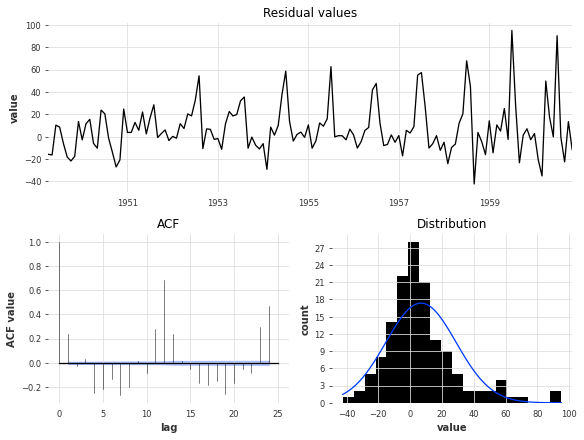

In [16]:
plot_residuals_analysis(best_theta_model.residuals(series))

Distributionのピークが0より少し大きい<br/>
これはThetaモデルにバイアスがあることを意味するらしい

ACFで12のところで大きな値があるのは、残差に何らかの情報があるということ<br/>
今回の場合では、モデルが周期性をうまく使えていないといえる

### ExponentialSmoothing modelの場合

  0%|          | 0/69 [00:00<?, ?it/s]

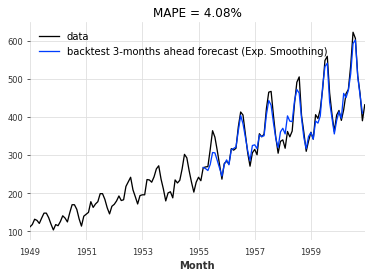

In [18]:
model_es = ExponentialSmoothing()
historical_fcast_es = model_es.historical_forecasts(series, start=pd.Timestamp('19550101'), forecast_horizon=3, verbose=True)

fig, ax = plt.subplots()
series.plot(label='data', ax=ax)
historical_fcast_es.plot(label='backtest 3-months ahead forecast (Exp. Smoothing)', ax=ax)
ax.set_title('MAPE = {:.2f}%'.format(mape(historical_fcast_es, series)))
ax.legend(loc='best')

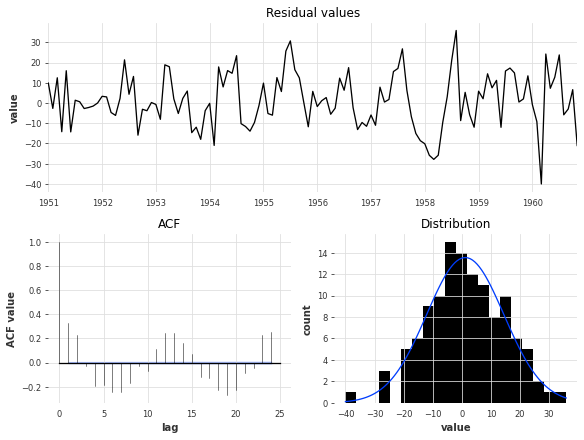

In [19]:
plot_residuals_analysis(model_es.residuals(series))

DistributionのピークがずれていることやACFに大きな値がある問題が解決した